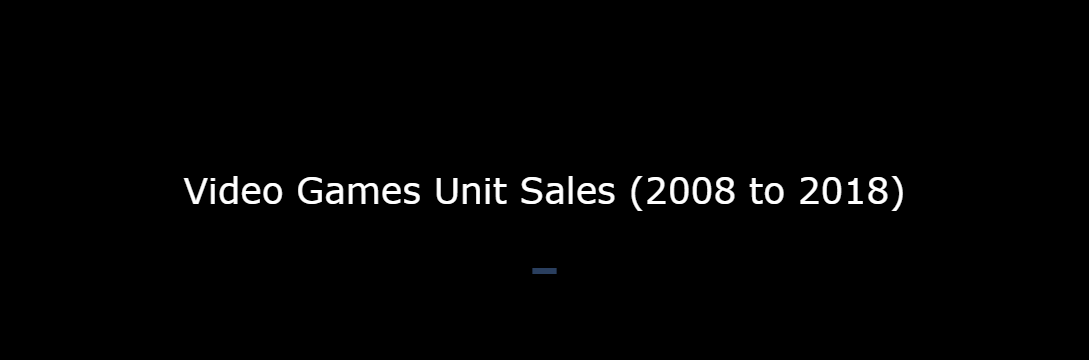

Dropdown(description='Year:', options=('All Years (2008-2018)', 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011…

Button(description='Update Dashboard', style=ButtonStyle())

Output()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
from ipywidgets import Output
from IPython.display import display
from IPython.display import clear_output


# Load and prepare the data
file_path = r"D:\Project\Python_Project\vgcharts_2024.csv"
df = pd.read_csv(file_path)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')  #This is to extract the year in release_date. Focusing on yearly performance
target_consoles = ['PS3', 'PS4', 'X360', 'PC']                            #Minimizing the target console to PS3, PS4, X360 and PC.

# Generate year options
years = sorted(df['release_date'].dt.year.dropna().unique())
years = [year for year in years if 2008 <= year <= 2018]                  #Only from year 2008 to 2018 will be included in dropdown.
years_dropdown = ['All Years (2008-2018)'] + sorted(years, reverse=True)

fig_title = go.Figure()
fig_title.add_trace(go.Indicator(
mode="number",
title="Video Games Unit Sales (2008 to 2018)",
title_font_size = 36,
title_font_color = "white",
domain={'x': [0, 1], 'y': [0, 0.5]}
))
fig_title.update_layout(
    paper_bgcolor="black",  # Background color
    plot_bgcolor="black",
    margin=dict(t=10, b=10, l=20, r=20)  # Adjust padding
)
fig_title.show()

# Widgets
year_dropdown = widgets.Dropdown(
    options=years_dropdown,
    value='All Years (2008-2018)',
    description='Year:'
)

update_button = widgets.Button(description="Update Dashboard")
output = Output()

# Plotting function
def update_plot(_):
    with output:
        clear_output(wait=True)

        # Data Filtering
        filtered_df = df[
            df['release_date'].dt.year.between(2008, 2018) &            #Cleaning the data by minimizing the year. Include only year 2008 to 2018
            df['total_sales'].notnull() &                               #Removing the null data in total_sales.
            df['console'].isin(target_consoles)                         #See target_consoles above.
        ].copy() #Prevent modifying the original Dataframe

        
        # Additional filter for specific year
        selected_year = year_dropdown.value
        if selected_year != 'All Years (2008-2018)':
            filtered_df = filtered_df[filtered_df['release_date'].dt.year == selected_year]
       
        # 1-6 Data Aggregations
        # 1. Unit Sales by Console
        sales_by_console = filtered_df.groupby('console')['total_sales'].sum().reset_index()

        # 2. Unit sales by regions
        region_sales = {
            'NA': filtered_df['na_sales'].sum(),       #North America Region
            'JP': filtered_df['jp_sales'].sum(),       #Japan Region
            'PAL': filtered_df['pal_sales'].sum(),     #Europe Region and other country uses a PAL TV format
            'Other': filtered_df['other_sales'].sum()} #Other region
        region_df = pd.DataFrame.from_dict(region_sales, orient='index', columns=['total_sales']).reset_index()
    
        # 3. Yearly Unit Sales by Console
        
        yearly_console_performance = filtered_df.groupby(['console', filtered_df['release_date'].dt.year.rename('Year')]).agg(
        total_sales=('total_sales', 'sum')).reset_index()
        
        # 4. Top 10 Unit Sales made by Publisher
        publisher_sales = filtered_df.groupby('publisher')['total_sales'].sum().reset_index().sort_values('total_sales', ascending=False).head(10)
        # 5. Top 5 Genre Unit Sales with Publisher's name
        publisher_genre_sales = filtered_df.groupby(['publisher', 'genre'])['total_sales'].sum().reset_index().sort_values(
            'total_sales', ascending=False).head(5)
        # 6. Top 5 Developer Unit Sales with Publisher's name
        publisher_developer_sales = filtered_df.groupby(['publisher', 'developer'])['total_sales'].sum().reset_index().sort_values(
            'total_sales', ascending=False).head(5)
            

        plt.figure(figsize=(12, 6))
        sns.lineplot(x='Year', y='total_sales', 
                     data=yearly_console_performance[yearly_console_performance['console'] == 'PS4'], 
                     marker='o', label='PS4', color='#1f77b4', linewidth = 2)
        sns.lineplot(x='Year', y='total_sales', 
                     data=yearly_console_performance[yearly_console_performance['console'] == 'PS3'], 
                     marker='s', label='PS3', color='#ff7f0e', linewidth=2)
        sns.lineplot(x='Year', y='total_sales', 
                     data=yearly_console_performance[yearly_console_performance['console'] == 'X360'], 
                     marker='D', label='X360', color='#2ca02c', linewidth = 2)
        sns.lineplot(x='Year', y='total_sales', 
                     data=yearly_console_performance[yearly_console_performance['console'] == 'PC'], 
                     marker='v', label='PC', color='#d62728', linewidth=2)

        plt.xlabel('Year (2008-2018)')
        plt.ylabel('Unit Sales (in Millions)')
        plt.title(f'Trend of Unit Sales of Video Games by Console ({selected_year})')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        fig_bar1 = px.bar(
        sales_by_console,
        x='console',
        y='total_sales',
        title=f"Unit Sales by Console ({selected_year})",
        text=round(sales_by_console['total_sales'], 1),
        labels={'total_sales': 'Total Unit Sales (in Millions)', 'console': 'Console'}
        )
        fig_bar1.show()
        
        fig_pie1 = px.pie(
        sales_by_console,
        names='console',
        values='total_sales',
        title=f"Proportion of Console Unit Sales ({selected_year})",
        hover_data=['total_sales'],
        labels = {'total_sales': 'Unit Sales (in Millions) by Publisher'})
        fig_pie1.show()
     
        # 2. Region Sales Plot
        fig_bar2 = px.bar(
        region_df,
        x='index',
        y='total_sales',
        text=round(region_df['total_sales'], 1),
        title=f"Regional Unit Sales ({selected_year})",
        labels={'total_sales': 'Unit Total Sales (in Millions)', 'index': 'Region'}
        )
        fig_bar2.show()

        fig_pie2 = px.pie(
        region_df,
        names='index',
        values='total_sales',
        title=f"Proportion of Regional Unit Sales ({selected_year})",
        hover_data=['total_sales'],
        labels = {'total_sales': 'Unit Sales (in Millions) by Publisher'})
        fig_pie2.show()

        plt.figure(figsize=(12, 6))
        sns.barplot(
            x='publisher', 
            y='total_sales', 
            data=publisher_sales, 
            palette='viridis',
            hue = 'publisher'
            )
        plt.xlabel('Game Publisher')
        plt.ylabel('Total Unit Sales')
        plt.title(f"Top 10 Publisher by Unit Sales ({selected_year})")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show() 

        fig_pie3 = px.pie(
        publisher_sales,
        names='publisher',
        values='total_sales',
        title=f"Top 10 Publisher by Unit Sales ({selected_year})",
        hover_data=['total_sales'],
        labels = {'total_sales': 'Unit Sales (in Millions) by Publisher'})
        fig_pie3.show()

        fig_treemap = px.treemap(
        publisher_genre_sales, 
        path=['publisher', 'genre'], 
        values='total_sales',
        title=f"Top Publisher-Genre Combinations by Sales ({selected_year})",
        hover_data={'total_sales': ':.1f'},  # Show 1 decimal place
        labels={'total_sales': 'Unit Sales (Millions)'},
        color='total_sales',  # Color intensity by sales
        color_continuous_scale='Blues'  # Color gradient
        )
        fig_treemap.update_traces(
            textinfo="label+value"  # Show publisher + sales in boxes
        )
        fig_treemap.show()

        fig_treemap2 = px.treemap(
        publisher_developer_sales, 
        path=['publisher', 'developer'], 
        values='total_sales',
        title=f"Top Publisher-Developer Combinations by Sales ({selected_year})",
        hover_data={'total_sales': ':.1f'},  # Show 1 decimal place
        labels={'total_sales': 'Unit Sales (Millions)'},
        color='total_sales',  # Color intensity by sales
        color_continuous_scale='Greens'  # Color gradient
        )
        fig_treemap2.update_traces(
            textinfo="label+value"  
        )
        fig_treemap2.show()

        
# Button click listener
update_button.on_click(update_plot)

# Initial display
display(year_dropdown, update_button, output)
update_plot(None)  # Show initial chart for "All Years"